In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from wordcloud import WordCloud
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Bidirectional,Activation,Lambda,Input,Embedding,LSTM

In [121]:
df=pd.read_csv('/content/hindi_english_parallel.csv')
print(df.head())

                                               hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  


In [122]:
print(len(df))

1561841


In [123]:
# Checking for Null values
df.isnull().sum()

,0
hindi,6057
english,877


In [124]:
# Dropping null values and resetting the index
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [125]:

df.isnull().sum()

,0
hindi,0
english,0


In [126]:
len(df)

1555574

In [127]:
df['english']

,english
0,Give your application an accessibility workout
1,Accerciser Accessibility Explorer
2,The default plugin layout for the bottom panel
3,The default plugin layout for the top panel
4,A list of plugins that are disabled by default
...,...
1555569,शपथ लेने/प्रतिज्ञान करने वाले सदस्य
1555570,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1555571,है। I note that this is a landmark meeting – n...
1555572,है। In the presentations that they made before...


In [128]:
# There are some rows in english columns that contains hindi
df.iloc[155570]

,155570
hindi,"% 1 ने चैनल विषय को ""% 2"" पर सेट किया."
english,% 1 sets the channel mode '% 2'.


In [129]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


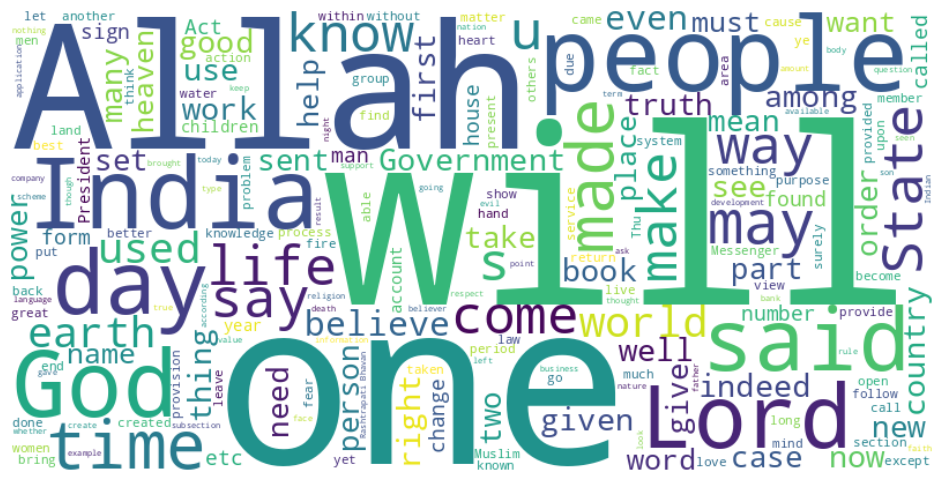

In [130]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Make sure to use the correct column name for English
corpus_list = []
for line in df['english']:   # change 'english' to your actual column name
    cleaned_line = re.sub(r'[^A-Za-z\s]', '', str(line))  # keep only English letters
    cleaned_line = ' '.join(cleaned_line.split())          # remove extra spaces
    corpus_list.append(cleaned_line)

corpus = ' '.join(corpus_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

plt.figure(figsize=(13,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [131]:
# Removing the rows that contains hindi sentences as it will just create noise in the dataset
def contains_Hindi(text):
    if isinstance(text,str):
        return bool(re.search(r'[\u0900-\u097F]',text))
    return False
df_filtered=df[~df['english'].apply(contains_Hindi)].reset_index(drop=True)

In [132]:
Embedding_dim=100
Latent_dim=400
max_seq_len=100
max_vocab_size=20000

In [133]:
# As the data size is large we will work with 20000 sentences
input_text=[]
target_text=[]
target_text_input=[]
translation=[]
i=19999
for j,t in enumerate(df['english']):
    input_text.append(t)
    if j==i:
        j=0
        break
for j,t in enumerate(df['hindi']):
    translation.append(t)
    target_text.append(t+' <eos>')
    target_text_input.append('<sos> '+t)
    if j==i:
        break

In [134]:
#Input
tokenizer_input=Tokenizer(num_words=max_vocab_size)
tokenizer_input.fit_on_texts(input_text)
tokenized_input=tokenizer_input.texts_to_sequences(input_text)

In [135]:
word2idx=tokenizer_input.word_index
print('word2idx length:',len(word2idx))

word2idx length: 2036


In [136]:
#Output
tokenizer_output=Tokenizer(num_words=max_vocab_size,filters='')
tokenizer_output.fit_on_texts(target_text_input+target_text)
tokenized_target=tokenizer_output.texts_to_sequences(target_text)              #target output
tokenized_target_input=tokenizer_output.texts_to_sequences(target_text_input)  #teacher forcing

In [137]:
word2idx_output=tokenizer_output.word_index
print('length of word2idx output:',len(word2idx_output))
num_words_output=len(word2idx_output)+1

length of word2idx output: 2936


In [138]:
import zipfile

# Extract the zip
with zipfile.ZipFile("/content/glove.6B.100d.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Now read the extracted file
word_vec = {}
with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        word_vec[word] = vector

print('length of word vector =', len(word_vec))



length of word vector = 400000


In [139]:
#Input
encoder_input=pad_sequences(tokenized_input,maxlen=max_seq_len)
print('Encoder input shape=',encoder_input.shape)

Encoder input shape= (20000, 100)


In [140]:
#target output as input for teacher forcing
decoder_input=pad_sequences(tokenized_target_input,maxlen=max_seq_len,padding='post')
print('decoder input shape:',decoder_input.shape)

decoder input shape: (20000, 100)


In [141]:
#target output
decoder_output=pad_sequences(tokenized_target,maxlen=max_seq_len,padding='post')
print('decoder output shape:',decoder_output.shape)

decoder output shape: (20000, 100)


In [142]:
#creating count matrix
num_words=min(max_vocab_size,len(word2idx)+1)
word_embedding=np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
    if i<max_vocab_size:
        vec=word_vec.get(word)
        if vec is not None:
            word_embedding[i]=vec
print('shape of word_embedding:',word_embedding.shape)

shape of word_embedding: (2037, 100)


In [143]:
embedding_layer_input=Embedding(num_words,
                          Embedding_dim,
                          weights=[word_embedding],
                          trainable=False)

In [144]:
#Encoder
encoder_input_placeholder=Input(shape=(max_seq_len,))
x=embedding_layer_input(encoder_input_placeholder)
encoder_lstm=LSTM(Latent_dim,return_state=True)
encoder_output,h,c=encoder_lstm(x)
encoder_states=[h,c]

In [145]:
#Decoder
decoder_input_placeholder=Input(shape=(max_seq_len,))
decoder_embedding=Embedding(num_words_output,Embedding_dim)
x=decoder_embedding(decoder_input_placeholder)
decoder_lstm=LSTM(Latent_dim,return_state=True,return_sequences=True)
decoder_outputs,_,_=decoder_lstm(x,initial_state=encoder_states)
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [146]:
model=Model([encoder_input_placeholder,decoder_input_placeholder],      # Teacher Forcing
            decoder_outputs)

In [147]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [148]:
hist=model.fit([encoder_input,decoder_input],
               decoder_output,
               epochs=100,
               validation_split=0.2,
               batch_size=64)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 273ms/step - accuracy: 0.9337 - loss: 1.0392 - val_accuracy: 0.9677 - val_loss: 0.2200
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9638 - loss: 0.2307 - val_accuracy: 0.9687 - val_loss: 0.1947
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9674 - loss: 0.1940 - val_accuracy: 0.9715 - val_loss: 0.1629
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9718 - loss: 0.1536 - val_accuracy: 0.9750 - val_loss: 0.1309
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.9766 - loss: 0.1176 - val_accuracy: 0.9792 - val_loss: 0.1011
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9817 - loss: 0.0885 - val_accuracy: 0.9830 - val_loss: 0.0777
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.9860 - loss: 0.0670 - val_accuracy: 0.9862 - val_loss: 0.0607
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9888 - loss: 

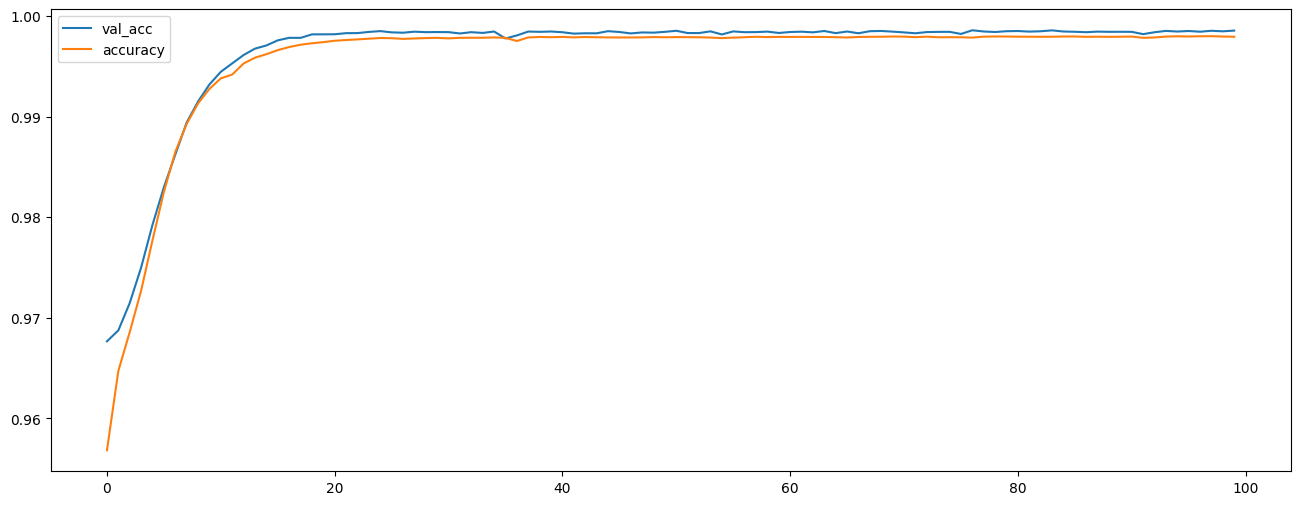

In [149]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

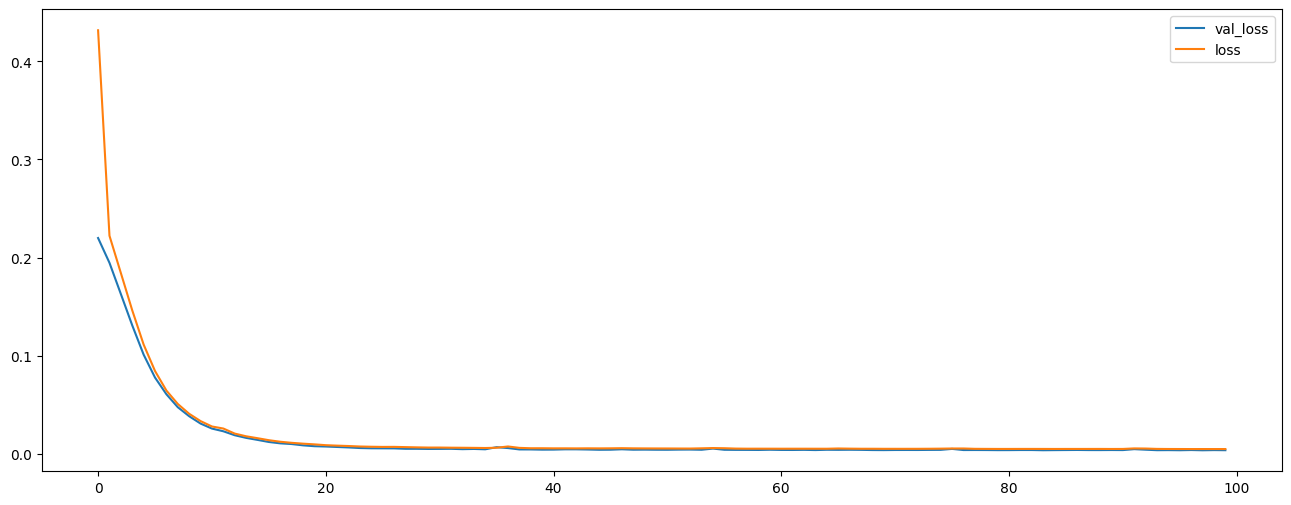

In [150]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

In [151]:
encoder_model=Model(encoder_input_placeholder,encoder_states)

In [152]:
# Decoder for prediction (one input at a time)
decoder_inital_h=Input(shape=(Latent_dim,))
decoder_inital_c=Input(shape=(Latent_dim,))

decoder_initial_states=[decoder_inital_h,decoder_inital_c]

decoder_input_single=Input(shape=(1,))
decoder_embedding_single=decoder_embedding(decoder_input_single)
decoder_outputs_x,h,c=decoder_lstm(decoder_embedding_single,initial_state=decoder_initial_states)

decoder_states=[h,c]

decoder_output=decoder_dense(decoder_outputs_x)

decoder_model=Model([decoder_input_single]  +  decoder_initial_states,
                    [decoder_output]  +  decoder_states
                   )

In [153]:
idx2word_output={v:k for k,v in word2idx_output.items()}

In [154]:
def decode_sequence(sequence):
    states_value=encoder_model.predict(sequence,verbose=0)     # context vector:-will return [h,c]

    target_seq=np.zeros((1,1))
    target_seq[0,0]=word2idx_output['<sos>']    #First input to decoder

    eos=word2idx_output['<eos>']

    output_sequence=[]

    for _ in range(max_seq_len):
        output_token,h,c=decoder_model.predict([target_seq]+states_value,verbose=0)

        idx=np.argmax(output_token[0,0,:])

        if idx==eos:                       # if the predicted token is <eos>
            break

        if idx>0:
            output_sequence.append(idx2word_output[idx])

        target_seq[0,0]=idx

        states_value=[h,c]

    return ' '.join(output_sequence)

In [172]:
i=0
while i<10:
    j=np.random.choice(len(encoder_input))
    input_seq=encoder_input[j:j+1]
    seq=decode_sequence(input_seq)
    print('------------------')
    print('input text:',input_text[j])
    print('real output',translation[j])
    print('predicted output:',seq)
    i+=1

------------------
input text: Filter
real output फ़िल्टर
predicted output: फ़िल्टर
------------------
input text: Retrieving status…
real output पुनःप्राप्त कर रहा है स्थिति
predicted output: पुनःप्राप्त कर रहा है स्थिति
------------------
input text: Remove the jack of diamonds.
real output ईंट का बादशाह हटाएँ. 
predicted output: ईंट का बादशाह हटाएँ.
------------------
input text: Sorted by most recent use
real output छांटा हुआ द्वारा
predicted output: छांटा हुआ द्वारा
------------------
input text: A process is already running. Would you like to terminate it and attach the new process?
real output A process है कार्यशील जैसा को और नया process? 
predicted output: a process है कार्यशील जैसा को और नया process?
------------------
input text: Remove the nine of clubs.
real output चिड़ी का बादशाह हटाएँ. 
predicted output: चिड़ी का बादशाह हटाएँ.
------------------
input text: Place a two in the leftmost slot of row ~ a.
real output पंक्ति ~ a के सबसे बायें के स्लॉट में दो को रखें. 
predicte

In [173]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import re

# Smoothing method better for short sentences
smooth = SmoothingFunction().method5

# Function to clean text: lowercase, strip, remove punctuation
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text

bleu_scores = []
for ref, pred in zip([translation[i] for i in sample_indices], predicted_outputs):
    ref_clean = clean_text(ref)
    pred_clean = clean_text(pred)

    # Weighted n-grams: emphasize 1-gram and 2-gram for short sentences
    bleu = sentence_bleu(
        [ref_clean.split()],
        pred_clean.split(),
        weights=(0.5, 0.5, 0, 0),
        smoothing_function=smooth
    )
    bleu_scores.append(bleu)

avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU: {avg_bleu:.4f}")


Average BLEU: 0.7126
